In [28]:
import os
import pandas as pd
import networkx as nx

In [29]:
from toposort import toposort, toposort_flatten

In [30]:
from collections import defaultdict 

In [31]:
path = "./"

In [32]:
# list of folders of the given path is assigned to the variable folder_list
folder_list = [each for each in list(os.walk(path))[0][1] if "python" in each]

In [33]:
# variable to be identify
variables_to_look = ['depends','makedepends']

In [34]:
# optional function which identifies whether the given line contains a variable or not
def variable_or_not(line):
    
    if "=" in line and len(line.strip().split("=")[0].split(" "))==1:
        return each_line.strip().split("=")[0]
    else:
        return False
    

In [35]:
# start reading the dependencies

# flag is set to True if the desired variable is there in the line
flag = False

# this dictionary will contain keys as package names and values as dependecies
main_depends = {}

# iterates through all the items in the folder_list
for each_folder in folder_list:
    
    if os.path.isfile(path+each_folder+"/PKGBUILD"):
        # opens the file 
        with open(path+each_folder+"/PKGBUILD",'r') as file:

            # this variable contains all the lines of the given file
            temp = file.readlines()

            # stack is sub-list which will contain all the dependecies of the file
            stack = []

            # iterates through each line of the given file
            for each in temp:

                # checks if the desired varable is at the given line
                if each.split("=")[0] in variables_to_look:
                    flag = True

                # if variable is found
                if flag == True:

                    # appends the line if flag is true
                    stack.append(each.strip().replace("'",""))
                    #print(each.strip().replace("'",""))

                # if the bracket is being ended 
                if ')' in each.strip():
                    flag = False

                    # if there is dependencies availabe or not
                    if len(stack) > 0:
                        main_depends[each_folder] = stack
                    else:
                        main_depends[each_folder] = None

            
# this loop will clear the string of the main_depends       
for each in list(main_depends.keys()):
    
    temp = []
    
    # iterates through list for given key
    for x in main_depends[each]:
        temp.append(x.split("=")[-1])
    
    # clears the line and gets the names of the dependencies
    main_depends[each] = set([each for each in " ".join(temp).replace("(","").replace(")","").split(" ") if len(each)>0])


In [36]:
# all the names of the modules which are in the folders
main_modules = list(main_depends.keys())

# all the names of the main modules and its dependecies, general list
all_modules = list(set([j for i in list(main_depends.values()) for j in i]+main_modules))

In [37]:
# dataframe with index and columns as list of all the modules
main_frame = pd.DataFrame(columns=all_modules,index=all_modules).fillna(0)

In [38]:
# iterates through each cell value of the dataframe
for ind in list(main_frame.index):
    for col in list(main_frame.columns):
        
        # checks if the given index is in the main module list and index and column names are not same
        if ind in main_modules and col!=ind:
            
            # iterates through the list of dependencies for the given module
            for each in main_depends[ind]:
                
                # set the cell value to 1 if there is dependencies between two modules
                main_frame.loc[ind,each] = 1
        

In [39]:
main_frame.iloc[0]['python']

0

In [40]:
main_frame = main_frame

In [41]:
def get_depends(pack):
    return main_frame.index[main_frame[pack] == 1].tolist()

In [42]:
get_depends('python')

['python-banana',
 'python-dog',
 'python-cat',
 'python-cactus',
 'python-elephant',
 'python-apple']

In [43]:
def flat(lis):
    
    temp = []
    
    for each in lis:
        
        if type(each) == str:
            temp.append(each)
        else: 
            for x in each:
                temp.append(x)
        
    return temp

In [44]:
def custom_list(pack):
    label = "lavel-"
    levels = {}

    current_level = 0
    levels[label+str(current_level)] = [pack]
    
    bases = []
    
    #for each in list(main_frame.columns):
        
        #if len(get_depends(each)) == 0:
            #bases.append(each)
        
    level_list = get_depends(pack)
    
    if len(level_list) == 0:
        return {}

    while len(level_list) !=0 :
        
        
        #print(current_level,"|",level_list,"|",levels)
        #print(levels)
        temp = []
        for each in level_list:

            if each not in flat(list(levels.values())):
                
                if each not in bases:
                    temp.append(each)
                
        #current_level +=1
        
        #print(current_level,temp)
        if len(temp)>0:
            levels[label+str(current_level)] = temp

            
            level_list = flat([get_depends(x) for x in temp if len(get_depends(x)) >= 1])
            
            if len(level_list):
                current_level +=1
        else:
            level_list = []
            
           
    levels['base'] = bases
    
    return levels

In [45]:
custom_list('python-dog')

{}

In [46]:
main_frame

,python,python-banana,python-dog,python-cat,python-cactus,python-elephant,python-apple,python-setuptools
python,0,0,0,0,0,0,0,0
python-banana,1,0,0,1,0,0,1,0
python-dog,1,0,0,0,0,1,0,0
python-cat,1,0,0,0,0,0,1,1
python-cactus,1,1,0,0,0,0,0,0
python-elephant,1,0,0,0,0,0,1,0
python-apple,1,0,0,0,0,0,0,1
python-setuptools,0,0,0,0,0,0,0,0


In [47]:
import matplotlib.pyplot as plt

In [48]:
from pyvis.network import Network

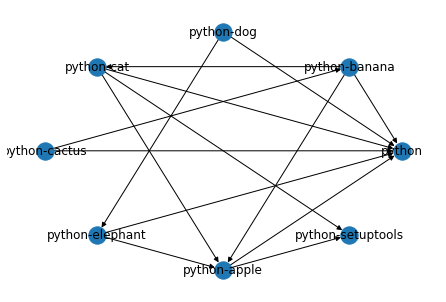

In [49]:
G = nx.DiGraph(directed = True)

for each in list(main_frame.index):
    G.add_node(each)
    
for row in list(main_frame.index):
    for col in list(main_frame.columns):
        
        if main_frame.loc[row,col]==1:
            G.add_edge(row,col)

nt = Network("500px", "500px")
nt.from_nx(G)
nt.show("nx.html")
nx.draw_shell(G,with_labels=True)
plt.savefig("graph.png")


In [50]:
for each in list(main_frame.columns):
    print(each ,":\n",flat(list(custom_list(each).values())))
    print("\n")

python :
 ['python-banana', 'python-dog', 'python-cat', 'python-cactus', 'python-elephant', 'python-apple']


python-banana :
 ['python-cactus']


python-dog :
 []


python-cat :
 ['python-banana', 'python-cactus']


python-cactus :
 []


python-elephant :
 ['python-dog']


python-apple :
 ['python-banana', 'python-cat', 'python-elephant', 'python-cactus', 'python-dog']


python-setuptools :
 ['python-cat', 'python-apple', 'python-banana', 'python-banana', 'python-elephant', 'python-cactus', 'python-cactus', 'python-dog']




In [51]:
# number of dependecies count
for each in range(len(main_frame.index)):
    print("Module:{0}, Count {1}".format(list(main_frame.index)[each],list(main_frame.iloc[each]).count(1)))

Module:python, Count 0
Module:python-banana, Count 3
Module:python-dog, Count 2
Module:python-cat, Count 3
Module:python-cactus, Count 2
Module:python-elephant, Count 2
Module:python-apple, Count 2
Module:python-setuptools, Count 0


In [52]:
# sorts the graph in topological order
toposort_flatten(main_depends)

['python',
 'python-setuptools',
 'python-apple',
 'python-cat',
 'python-elephant',
 'python-banana',
 'python-dog',
 'python-cactus']

In [53]:
# circular dependecies
data = {
    
1:{2},
2:{1},
3:{4},
4:{5}
}

toposort_flatten(data)

CircularDependencyError: Circular dependencies exist among these items: {1:{2}, 2:{1}}

In [ ]:
import jenkins

In [ ]:
server = jenkins.Jenkins('http://192.168.52.13:8090', username='yugantm', password='1234')
user = server.get_whoami()
version = server.get_version()
print('Hello %s from Jenkins %s' % (user['fullName'], version))

In [ ]:
server.build_job('python-add')

In [59]:
main_frame[['python','python-cat']].T[['python','python-cat']].T

,python,python-cat
python,0,0
python-cat,1,0
